In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import dlc_bci as bci
from dlc_practical_prologue import *

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

Load dataset

In [2]:
# Load dataset
tr_input, tr_target = bci.load("bci", train=True, one_khz=False)
te_input, te_target = bci.load("bci", train=False, one_khz=False)

# Prepare onehot vector for computation of loss
tr_target_onehot = convert_to_one_hot_labels(tr_input, tr_target)
te_target_onehot = convert_to_one_hot_labels(te_input, te_target)

Standardize

In [3]:
# normalize
tr_input = torch.nn.functional.normalize(tr_input, p=2, dim=0) 
te_input = torch.nn.functional.normalize(te_input, p=2, dim=0) 

# Convert to 4D tensor [dataset size, number of channels, rows, cols]
tr_input = tr_input[:, np.newaxis, :, :]
te_input = te_input[:, np.newaxis, :, :]

# Convert to pytorch variable
tr_input, tr_target, tr_target_onehot = Variable(tr_input), Variable(tr_target), Variable(tr_target_onehot)
te_input, te_target, te_target_onehot = Variable(te_input), Variable(te_target), Variable(te_target_onehot)

Output of NN is still a vector (cross entropy loss handles log-softmax)

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(28, 5), stride=2)
        self.conv1b = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(28, 10), stride=2)
        self.conv1c = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(28, 15), stride=2)
        
        self.conv2a = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 5), stride=2)
        self.conv2b = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 10), stride=2)
        self.conv2c = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(1, 15), stride=2)
        
        self.fc1 = nn.Linear(346, 200)
        self.fc2 = nn.Linear(200, 2)
        
    def forward(self, x, mode=False):
        
        # convolve
        x1a = self.conv1a(x)
        x1b = self.conv1b(x)
        x1c = self.conv1c(x)
        
        # reshape and concat
        x = torch.cat((x1a.view(x1a.size(0), -1), x1b.view(x1b.size(0), -1), x1c.view(x1c.size(0), -1)), 1)    
        x = x.view(x.size(0), 1, 1,-1)
        
        # convolve
        x2a = self.conv2a(x)
        x2b = self.conv2b(x)
        x2c = self.conv2c(x)
        
        x = torch.cat((x2a.view(x2a.size(0), -1), x2b.view(x2b.size(0), -1), x2c.view(x2c.size(0), -1)), 1)
        
        # fc
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=mode)
        x = self.fc2(x)
        return x

In [5]:
# construct and train model
model = Net()
tr_loss, te_loss = bci.train_model(model, tr_input, tr_target, 4, te_input, te_target, 4, 200)
#torch.save(model.state_dict(), os.getcwd() + "v1.pth")

# compute train and test errors
nb_tr_errors = bci.compute_nb_errors(model, tr_input, tr_target_onehot, 4, True)
nb_te_errors = bci.compute_nb_errors(model, te_input, te_target_onehot, 4, False)

print('tr error {:0.2f}% {:d}/{:d}'.format((100 * nb_tr_errors) / tr_input.size(0), nb_tr_errors, tr_input.size(0)))
print('te error {:0.2f}% {:d}/{:d}'.format((100 * nb_te_errors) / te_input.size(0), nb_te_errors, te_input.size(0)))

epoch 0 tr loss 55.77 te loss 17.73
epoch 1 tr loss 55.32 te loss 17.52
epoch 2 tr loss 55.43 te loss 17.37
epoch 3 tr loss 55.18 te loss 17.38
epoch 4 tr loss 55.07 te loss 17.38
epoch 5 tr loss 55.06 te loss 17.37
epoch 6 tr loss 55.02 te loss 17.38
epoch 7 tr loss 55.07 te loss 17.38
epoch 8 tr loss 55.02 te loss 17.37
epoch 9 tr loss 55.07 te loss 17.37
epoch 10 tr loss 54.98 te loss 17.38
epoch 11 tr loss 55.06 te loss 17.40
epoch 12 tr loss 54.98 te loss 17.41
epoch 13 tr loss 55.07 te loss 17.40
epoch 14 tr loss 54.98 te loss 17.41
epoch 15 tr loss 55.00 te loss 17.42
epoch 16 tr loss 55.11 te loss 17.42
epoch 17 tr loss 54.92 te loss 17.45
epoch 18 tr loss 54.97 te loss 17.45
epoch 19 tr loss 55.11 te loss 17.43
epoch 20 tr loss 55.04 te loss 17.44
epoch 21 tr loss 54.99 te loss 17.46
epoch 22 tr loss 55.03 te loss 17.46
epoch 23 tr loss 54.92 te loss 17.47
epoch 24 tr loss 54.95 te loss 17.49
epoch 25 tr loss 54.95 te loss 17.49
epoch 26 tr loss 54.84 te loss 17.49
epoch 27 tr

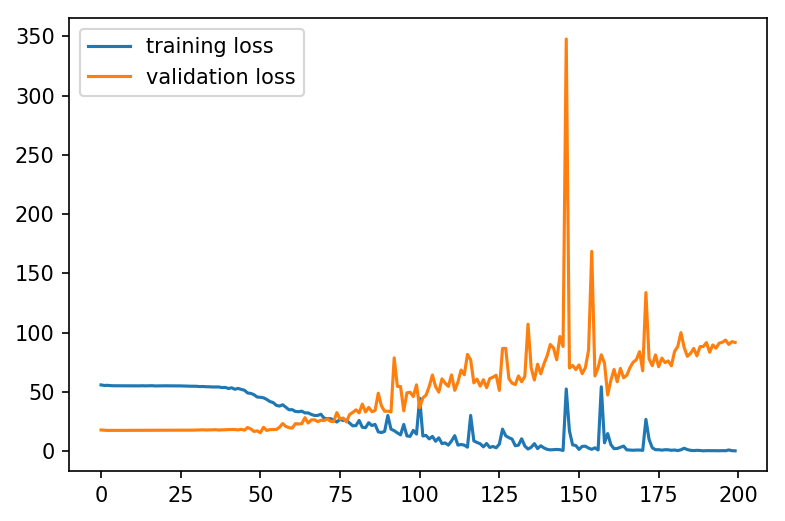

In [6]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

plt.figure()
plt.plot(tr_loss, label='training loss')
plt.plot(te_loss, label='validation loss')
plt.legend(loc='upper left')